Cluster the spectra from a folder full of MassBank .txt files
Read_massbank_file is modified from MassBank_processor

In [21]:
import glob
import numpy as np
import os
from collections import defaultdict, namedtuple

In [2]:
#encode a mass as an integer; does the rounding too
# these turn a float mass value into an integer that can be used to index the mass (in a dictionary)
# using precuison (e.g. 10 mmu) rounds the code and serves to merge similar values (not perfect - related
# values may be in adjacent bins)
#
def mencode(mass, precision):
    code = int(round(mass/precision, 0))
    return code
#
def decodem(code, precision):
    mass = float(code) * precision
    return mass
#

In [13]:
# Reads a MassBank file and merges entries within the specified precision
# The header lines are read without processing and converted to a list - headers
# the peaks are stored as a dictionary - key = mass coded with provided precision, value = intensity
# 
# If any masses generated the same code, their intensities are added, i.e. the peaks are merged
def read_massbank_file(f_name, precision):
    from collections import defaultdict
    headers = []
    peaks=defaultdict(int)
    processing_peaks = False
    mw=0
    base_inten=0
    with open(f_name) as f:
        for line in f:
            if '//' in line:
                break
            elif processing_peaks:        
                parts = line.strip().split(' ')
                mass, inten = float(parts[0]), int(parts[1])
                mass_code = mencode(mass, precision)
                peaks[mass_code] += inten
                if peaks[mass_code] > base_inten:
                    base_inten = peaks[mass_code]
            elif 'PK$' not in line:     #nothing to do with peaks...
                headers += [line[:-1]]  #remove the newline character
                if 'CH$EXACT_MASS' in line:
                    parts=line.split(':')
                    print line
                    mw = float(parts[1])
            elif 'PK$PEAK:' in line:    #start of peak secion
                processing_peaks = True            
    return headers, peaks, mw, base_inten

In [34]:
#define and test ConsensuPeak
ConPeak = namedtuple('ConPeak', 'Compound RI')
cpeak=ConPeak('Benzene', RI=0.1)
cpeak.RI

0.1

In [35]:
cd /Users/ronbonner/Data/HMDB spectra/

/Users/ronbonner/Data/HMDB spectra


In [36]:
# Generate consensus dictionary
#
# Reads a set of Massbank files and builds a dictionary:
#   key = mass_key_as_int (obtained by using mencode)
#   value = list of tuples(compound, relative int)..i.e. the relative intensity of this mass for the compound
# This assumes the names are unique

data_path = 'positive/*.txt'
header_lines = []
consensus_peaks = defaultdict(list)
compound_count = 0
precision=0.01
#
for f_name in glob.glob(data_path):
    _,tail = os.path.split(f_name)
    compound_count += 1
    compound = unicode(tail[:-4], 'ascii', 'ignore')     #ignore extension and get rid of weird characters
    if '\xe2' in f_name:
        print 'xe2 in:', f_name, compound
    header_lines, peaks_in, mw, base_inten = read_massbank_file(f_name, precision)
    for k, v in peaks_in.iteritems():
        consensus_peaks[k].append(ConPeak(compound, float(v)/base_inten))
print len(consensus_peaks), compound_count
#
for k in consensus_peaks.keys()[:5]:
    print decodem(k, precision), consensus_peaks[k]

3030 400
81.98 [ConPeak(Compound=u'3-Phosphoglyceric acid', RI=0.0007), ConPeak(Compound=u'Glycerol 3-phosphate', RI=0.0006), ConPeak(Compound=u'Phosphoenolpyruvic acid', RI=0.0014), ConPeak(Compound=u'Phosphonoacetate', RI=0.0005)]
81.99 [ConPeak(Compound=u'2-Amino-3-phosphonopropionic acid', RI=0.0024), ConPeak(Compound=u'Dimethyl sulfone', RI=0.0033)]
82.02 [ConPeak(Compound=u'Furosemide', RI=0.027066666666666666)]
82.03 [ConPeak(Compound=u'5-Hydroxymethyluracil', RI=0.5495), ConPeak(Compound=u'6-Methyladenine', RI=0.003), ConPeak(Compound=u'Flavin Mononucleotide', RI=0.0013), ConPeak(Compound=u'Ribothymidine', RI=0.0192), ConPeak(Compound=u'Thymidine', RI=0.0112), ConPeak(Compound=u'Thymine', RI=0.0558), ConPeak(Compound=u'Uridine', RI=0.0175)]
82.04 [ConPeak(Compound=u'(+)-(S)-Carvone', RI=0.0005983246908655763), ConPeak(Compound=u'1-Methylguanine', RI=0.0277), ConPeak(Compound=u"2'-Deoxyguanosine 5'-monophosphate", RI=0.0032), ConPeak(Compound=u'2,4-Dihydroxybenzoic acid', RI=0.0

In [37]:
#Sort the consensus dictionary by value in reverse order (i.e. decreasing number of occurences
#import operator
#s = sorted(consensus_peaks.items(), key=operator.itemgetter(1), reverse=True)
#s = sorted(consensus_peaks, key=lambda k: len(consensus_peaks[k]), reverse=True)

In [38]:
# find significant masses, i.e. ones with more than one compound, and corresponding compounds
# dropping masses might lose compounds too
#signif_masses = [(m_code, cs) for m_code, cs in consensus_peaks.iteritems() if len(cs) > 3]
sorted_codes = sorted(consensus_peaks.keys())
signif_masses = [(m_code, consensus_peaks[m_code]) for m_code in sorted_codes if len(consensus_peaks[m_code]) > 3]
signif_comps = set()
for _, cs in signif_masses:
    for (name, ri) in cs:                 #get the name from the tuple
        signif_comps.add(name)            
comp_list = [c for c in signif_comps]     #convert to a list so we can retrieve later
print len(signif_masses), len(comp_list)

889 396


In [39]:
# now we can make an array to cluster
# first make a lookup dictionary for the compound names....speeds access?
# we also make a dictionary, indexed by compound name, that has a list of the significant mass code and RI..
# these 'spectra' are used for plotting
comp_indices = {c:i for i, c in enumerate(comp_list)}
signif_spectra = defaultdict(list)     # dictionary of the 'significant' peaks in each compound....stored as [(mass,ri)]
#
data = np.zeros((len(comp_list), len(signif_masses)), dtype=np.float64)
#
for m_inx in range(0, len(signif_masses)):              #iterate masses
    mass_code, clist = signif_masses[m_inx]     # don't use the mass, just the compound list [(name, ri)....]
    for con_pk in clist:
        c_inx = comp_indices[con_pk.Compound]   # look up the row index of the compound
        data[c_inx][m_inx] = con_pk.RI
        signif_spectra[c_name].append((mass_code, ri))
# test there are some non-zero values!
#for (x, y), element in np.ndenumerate(data):
#    if element > 0:
#        print x, y, decodem(signif_masses[y][0], precision), element   #get the coded mass from the signif_mass list and decode it


In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib.backends.backend_pdf import PdfPages

/Users/ronbonner/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [41]:
op_name='op - clusters'
#
writing_pdf=False
if writing_pdf:
    pp = PdfPages(op_name + '.pdf')

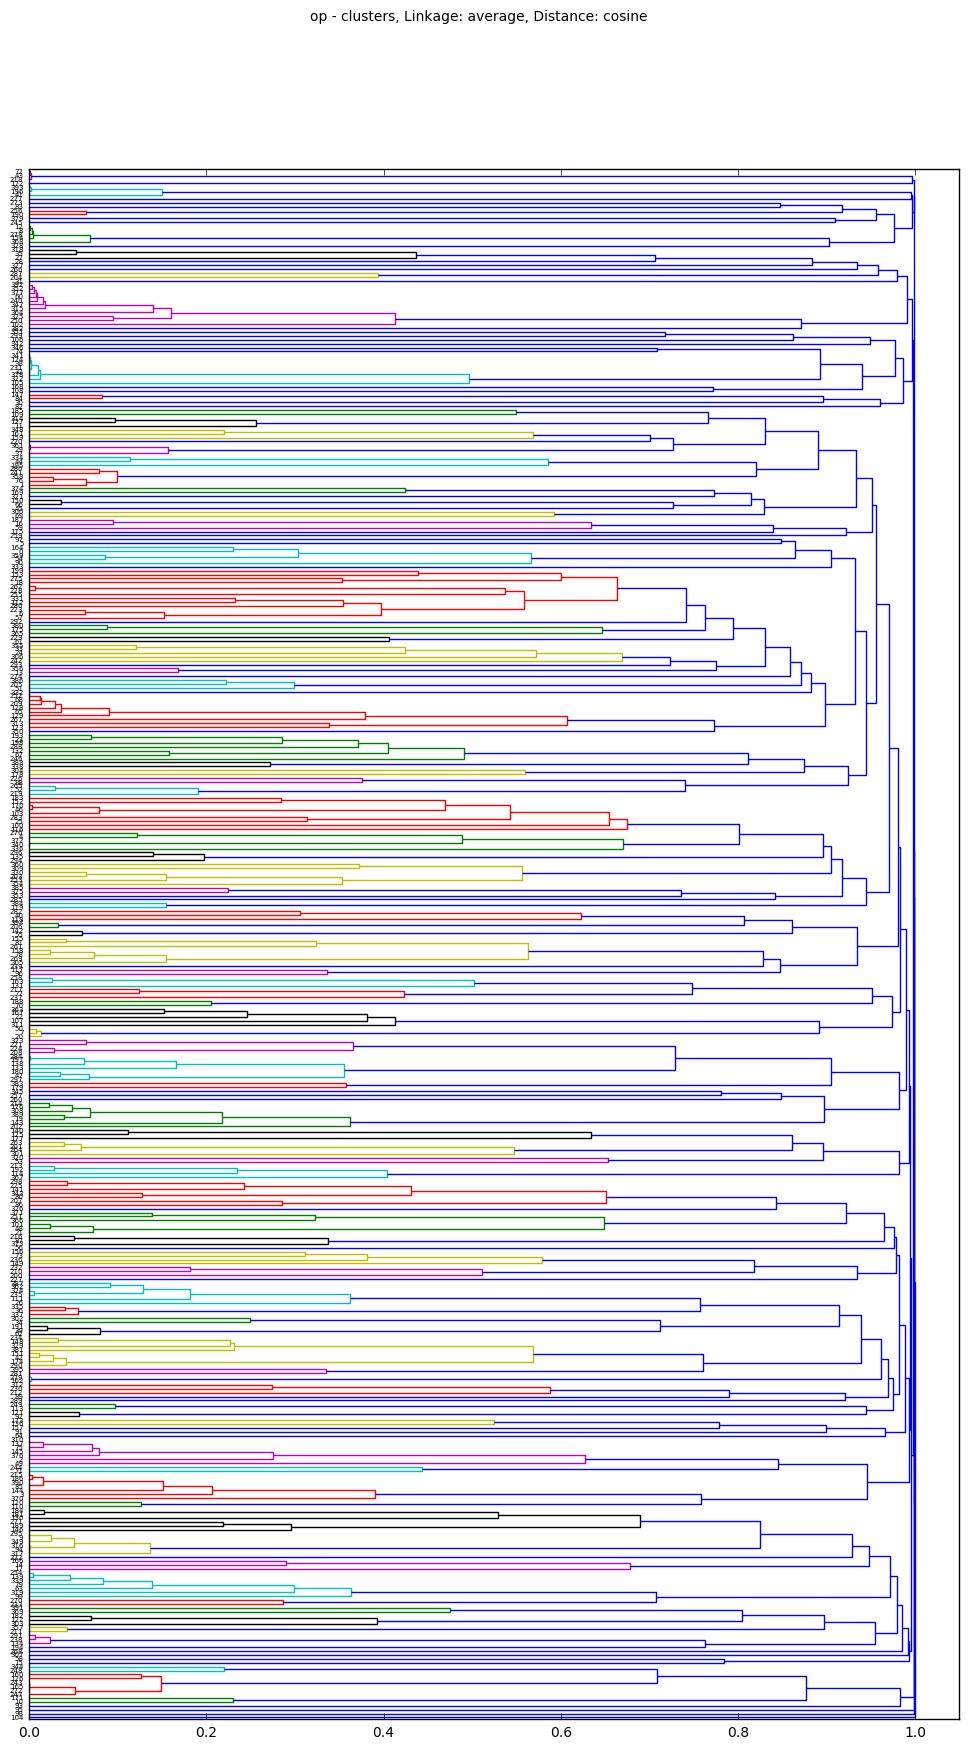

In [42]:
mpl.rcParams['lines.linewidth'] = 1      #change the default line width for thr dendrogram
#
link_type='average'
dist_metric='cosine'
plt_title='{}, Linkage: {}, Distance: {}'.format(op_name, link_type, dist_metric)
z=linkage(data, method=link_type, metric=dist_metric)
fig=plt.figure(figsize=(12,20))
fig.suptitle(plt_title)
#d=dendrogram(z, orientation='right', no_plot=False, truncate_mode='lastp', p=80, show_contracted=True)     #, labels=compound_names)
d=dendrogram(z, orientation='right', no_plot=False)     #, labels=compound_names)
plt.show()
if writing_pdf:
    pp.savefig(bbox_inches='tight')

(889, 396)


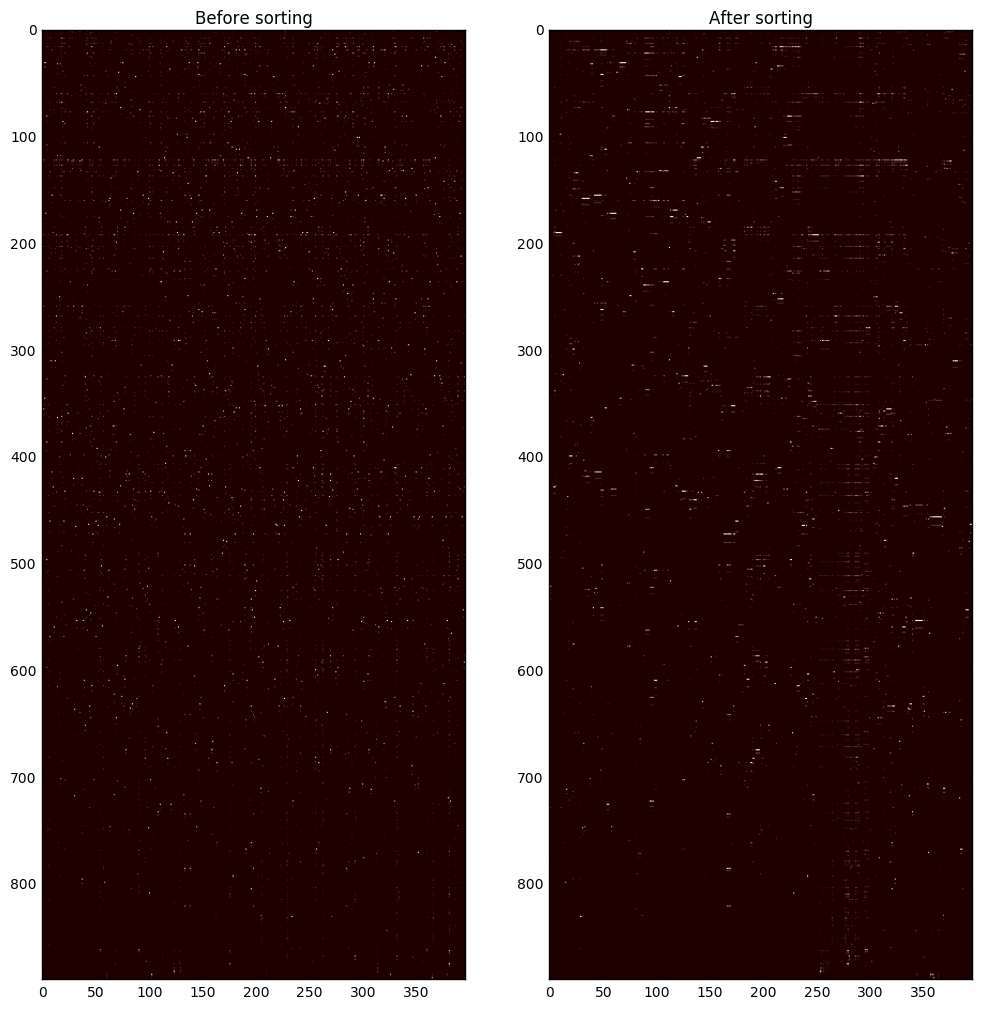

In [62]:
# Get the indices of the leaves - this is the order of the clusters
# generate a sorted subset
inx = d['leaves']
dists=np.transpose(data[inx,:])
print dists.shape
#
# Now plot the raw data and the sorted version
fig = plt.figure(figsize=(12,18))
asp=1
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(np.transpose(data), aspect=asp,cmap=plt.get_cmap('pink'))
a.set_title('Before sorting')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(dists, aspect=asp,cmap=plt.get_cmap('pink'))
a.set_title('After sorting')
plt.show()
if writing_pdf:
    pp.savefig(bbox_inches='tight')

In [64]:
# Use fcluster to retrieve the clusters at a given distance cut point
max_d = 0.35
clusters = fcluster(z, max_d, criterion='distance')
# Clusters is and array that indicates the assigned cluster for each entry (row) in the data
# We convert this to a dictionary with key=cluster number, value = [compound name]
cluster_dict = defaultdict(list)
clustered=0
for comp_inx, cluster_num in enumerate(clusters):
    cluster_dict[cluster_num].append(comp_list[comp_inx])
print len(cluster_dict), 'clusters'

220 clusters


In [66]:
c_count = defaultdict(int)
total=0
#
for k, v in cluster_dict.iteritems():
    comp_count = len(v)
    c_count[l] += comp_count
    total += l
    if comp_count >= 2:
        print k, comp_count, v
total,c_count

1 2 [u'Creatine', u'3-Methylindole']
2 6 [u'Beta-Alanine', u'Pantothenic acid', u'D-Alanine', u'L-Alanine', u'N-Acetyl-L-alanine', u'Sarcosine']
3 2 [u'Phosphocreatine', u'Creatinine']
7 3 [u'Thymine', u'Thymidine', u'Ribothymidine']
9 2 [u'Carnosine', u'L-Histidine']
10 2 [u'Imidazoleacetic acid', u'L-Histidinol']
14 2 [u'Biotin', u'Biocytin']
15 6 [u'N-Alpha-acetyllysine', u'Alpha-Aspartyl-lysine', u'L-Lysine', u'D-Lysine', u'Homocitrulline', u'Pipecolic acid']
17 2 [u'Acetylcysteine', u'L-Cysteine']
19 6 [u'Pyroglutamic acid', u'L-Glutamine', u'Pyrrolidonecarboxylic acid', u'D-Glutamine', u'L-Glutamic acid', u'N-Acetylglutamic acid']
20 3 [u'N-Formyl-L-methionine', u'N-Acetyl-L-methionine', u'L-Methionine']
21 2 [u'L-Threonine', u'L-Homoserine']
26 2 [u'Phosphorylcholine', u'PC(16-0-16-0)']
27 6 [u'Imipramine', u'L-Alloisoleucine', u'Glycyl-L-leucine', u'L-Norleucine', u'L-Leucine', u'L-Isoleucine']
31 6 [u'Betaine', u'Dimethylglycine', u'L-Alpha-aminobutyric acid', u'Trimethylamine

(220, defaultdict(int, {1: 396}))

In [85]:
names = []
use_clusters = [188,196]
title_str = 'Clusters: '
for cc in use_clusters:
    title_str = title_str + '{:.0f}({:.0f}), '.format(cc, len(cluster_dict[cc]))
    for c_name in cluster_dict[cc]:
        names.append(c_name)
len(names),names, title_str

(17,
 [u'Guanosine triphosphate',
  u'Guanosine',
  u'Guanosine monophosphate',
  u'Guanosine diphosphate',
  u'dGTP',
  u'Deoxyguanosine',
  u"2'-Deoxyguanosine 5'-monophosphate",
  u'Adenosine triphosphate',
  u'Adenine',
  u'NADH',
  u'Adenosine',
  u'Adenosine monophosphate',
  u'Deoxyadenosine monophosphate',
  u"5'-Methylthioadenosine",
  u'ADP',
  u'Cyclic AMP',
  u"Adenosine 2',3'-cyclic phosphate"],
 'Clusters: 188(7), 196(10), ')

In [86]:
consensus_peaks = set()
for c_name in names:
    for (m,ri) in signif_spectra[c_name]:
        consensus_peaks.add(m)
print len(consensus_peaks)

889


In [87]:
# These are the row indices of the compounds in the cluster
c_indices = [comp_indices[n] for n in names]

In [88]:
# these are those rows
c_spectra = data[c_indices, :]

In [89]:
# these are the column indices of the columns where at least one entry i > 0
m_indices = [m for m in range(len(signif_masses)) if sum(c_spectra[:,m]) > 0.01]
len(m_indices)

44

In [81]:
# these are the actual mass_codes
#[signif_masses[m][0] for m in m_indices]

In [82]:
c_spectra = c_spectra[:, m_indices]

In [83]:
#c_spectra

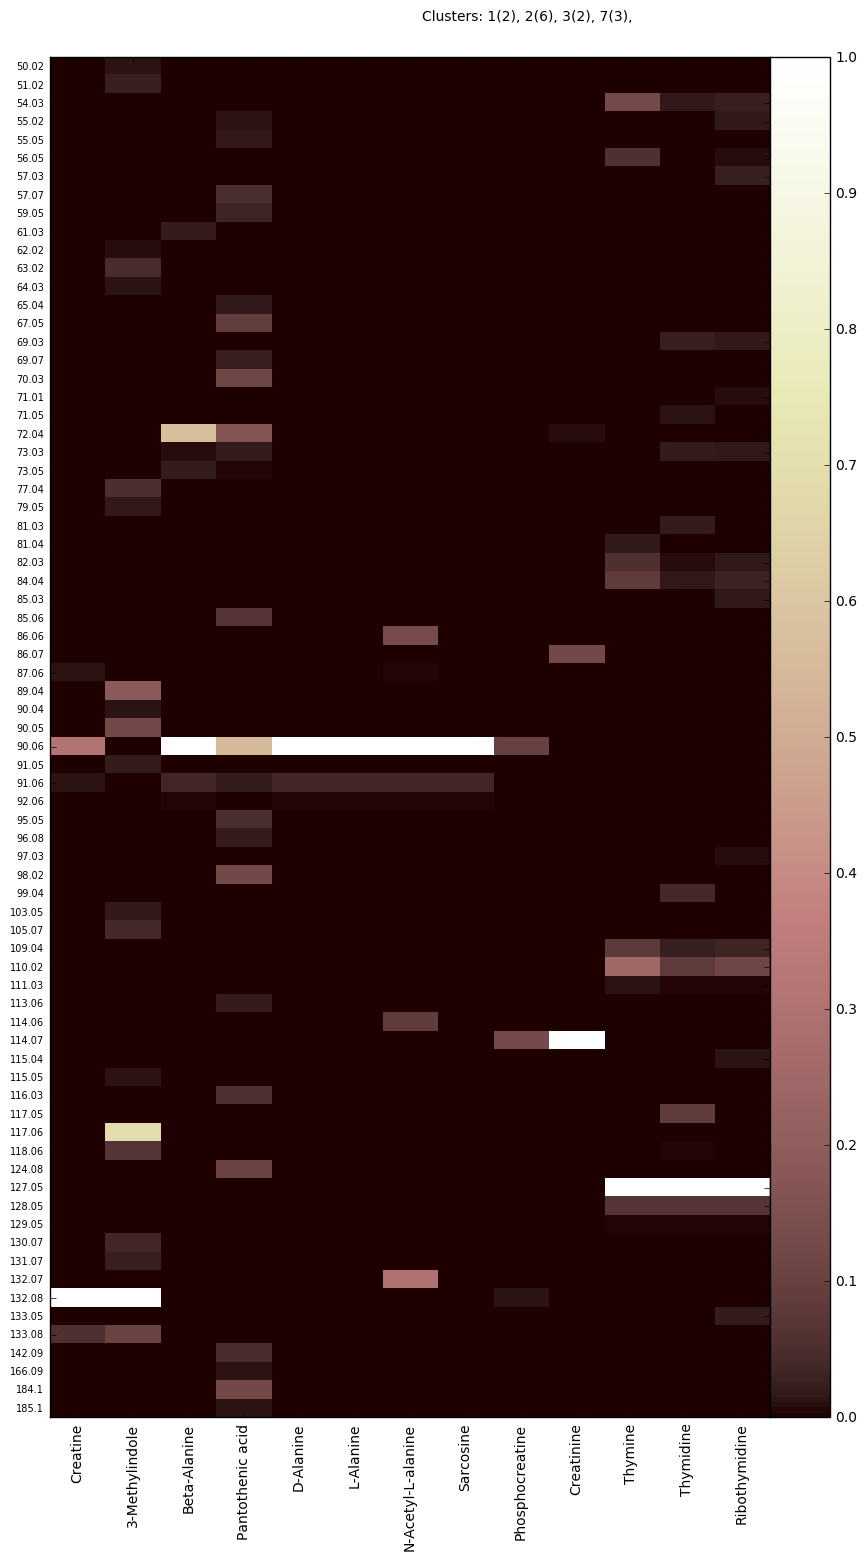

In [84]:
fig = plt.figure(figsize=(12,16))
fig.suptitle(title_str)
ax = fig.add_axes([0.1,0.1,0.6,0.85])
i = ax.imshow(np.transpose(c_spectra), aspect='auto', interpolation='nearest',cmap=plt.get_cmap('pink'))

ax.set_xticks(range(len(names)))
ax.set_yticks(range(len(m_indices)))

ax.set_yticklabels([decodem(signif_masses[m][0], precision) for m in m_indices], fontsize=7)
ax.set_xticklabels(names, rotation='vertical')

colorbar_ax = fig.add_axes([0.7, 0.1, 0.05, 0.85])
fig.colorbar(i, cax=colorbar_ax)
plt.show()
if writing_pdf:
    pp.savefig(bbox_inches='tight')

In [59]:
#pp.close()

In [60]:
#count the number of rows that have a given mass_code
for m in m_indices:   # mass codes
    print decodem(signif_masses[m][0], precision), len([x for x in data[:,m] if x > 0.0])

52.02 10
53.04 75
61.01 8
65.01 7
67.03 17
68.01 6
69.03 48
69.04 12
75.03 19
80.97 16
81.03 49
82.04 53
92.02 5
94.04 36
95.02 9
95.04 28
96.03 9
97.03 34
98.03 34
98.98 14
108.04 11
110.03 34
111.04 27
112.05 15
113.05 14
114.05 6
117.05 34
119.03 7
119.04 20
120.04 30
124.04 11
135.03 14
136.03 13
136.06 16
137.06 24
138.07 14
145.03 9
148.06 6
150.06 16
152.06 20
153.06 10
154.06 13
163.04 10
176.07 5
178.09 6
204.09 6
232.08 5
233.09 4
348.07 6
349.07 6
350.07 6
428.04 4
429.04 4
